In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#načítanie potrebných knižníc
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing
import numpy as np
import json
import re

#nastavenia
max_words = 20000  # maximálny počet slov vo vocab
max_length = 100   # maximálna dĺžka textov (v slovách)
embedding_dim = 128  # dimenzia embedding vrstvy

#funkcia na načítanie dát z JSONL súboru
def load_data_from_jsonl(jsonl_path):
    texts = []
    labels = []
    with open(jsonl_path, 'r') as file:
        for line in file:
            data = json.loads(line)
            texts.append(data["text"])
            labels.append(data["label"])
    return texts, labels

#funkcia na normalizáciu textu
def normalize_text(text):
    text = text.lower()  # zmena na malé písmená
    text = re.sub(r'[^a-zá-ž0-9\s]', '', text)  # odstránenie interpunkcie
    text = re.sub(r'\s+', ' ', text).strip()  # odstránenie nadbytočných medzier
    return text

#načítanie a normalizácia dát
train_jsonl_path = "/content/drive/MyDrive/data/train.jsonl"
test_jsonl_path = "/content/drive/MyDrive/data/test_seen.jsonl"

train_texts, train_labels = load_data_from_jsonl(train_jsonl_path)
test_texts, test_labels = load_data_from_jsonl(test_jsonl_path)

#normalizácia
train_texts = [normalize_text(t) for t in train_texts]
test_texts = [normalize_text(t) for t in test_texts]

#tokenizácia
tokenizer = preprocessing.text.Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

#padding
x_train = preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_length, padding='post')
x_test = preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_length, padding='post')

#konverzia štítkov
y_train = np.array(train_labels)
y_test = np.array(test_labels)

#výstupy na kontrolu
print(f"Počet tréningových vzoriek: {len(x_train)}")
print(f"Počet testovacích vzoriek: {len(x_test)}")
print(f"Tvar tréningových dát: {x_train.shape}, Tvar štítkov: {y_train.shape}")
print(f"Tvar testovacích dát: {x_test.shape}, Tvar štítkov: {y_test.shape}")


Počet tréningových vzoriek: 8500
Počet testovacích vzoriek: 1000
Tvar tréningových dát: (8500, 100), Tvar štítkov: (8500,)
Tvar testovacích dát: (1000, 100), Tvar štítkov: (1000,)


In [ ]:
#model BiLSTM, ak spúštame na novo trénovanie, tak hodnoty výslednych metrík budú o niečo iné ako uvedené v DP

In [ ]:
#importovanie potrebných knižníc
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
import numpy as np
import pandas as pd
import pickle
import os
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#načítanie datasetu
merged_csv_path = "/content/drive/MyDrive/data/new_merged.csv"
df = pd.read_csv(merged_csv_path)

#vyváženie datasetu: výber rovnakej veľkosti z oboch tried
class_0 = df[df['label'] == 0]
class_1 = df[df['label'] == 1]

#spojenie oboch tried do jedného balanced datasetu
min_class_size = min(len(class_0), len(class_1))
df_train = pd.concat([
    class_0.sample(n=min_class_size, random_state=42),
    class_1.sample(n=min_class_size, random_state=42)
])

df_test = df.drop(df_train.index)
from tensorflow.keras import layers, models, optimizers, losses, metrics
import numpy as np
import pandas as pd
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#načítanie datasetu
merged_csv_path = "/content/drive/MyDrive/data/new_merged.csv"
df = pd.read_csv(merged_csv_path)

# ✅ Ensure balanced dataset
class_0 = df[df['label'] == 0]
class_1 = df[df['label'] == 1]

# ✅ Balance the training dataset
min_class_size = min(len(class_0), len(class_1))
df_balanced = pd.concat([
    class_0.sample(n=min_class_size, random_state=42),
    class_1.sample(n=min_class_size, random_state=42)
])

#rozdelenie dát na trénovaciu a testovaciu množinu (80/20) so stratifikáciou
df_train, df_test = train_test_split(df_balanced, test_size=0.2, stratify=df_balanced["label"], random_state=42)

#zobrazenie distribúcie tried v trénovacej a testovacej množine
print(f"\n New Training Set Distribution:\n{df_train['label'].value_counts()}")
print(f" New Test Set Distribution:\n{df_test['label'].value_counts()}")

#extrakcia textov a ich štítkov
train_texts = df_train["clean text"].tolist()
train_labels = np.array(df_train["label"].tolist(), dtype=np.int32)

test_texts = df_test["clean text"].tolist()
test_labels = np.array(df_test["label"].tolist(), dtype=np.int32)

#nastavenie parametrov pre tokenizáciu
max_words = 10000   #maximálny počet slov
max_length = 100    #maximálna dĺžka sekvencie
embedding_dim = 100 #rozmer embedding vrstvy

#tokenizacia
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

#uloženie tokenizera na ďalšie použitie
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

#prevod textov na číselné sekvencie a padding
train_sequences = tokenizer.texts_to_sequences(train_texts)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

#výpočet váh tried počas trénovania
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))
print(f" Class Weights: {class_weight_dict}")

#nastavenie hyperparametrov
lstm_units = 64
dropout_rate = 0.5
learning_rate = 0.001
batch_size = 16
epochs = 10

#definovanie BiLSTM modelu
def build_bi_lstm_model():
    model = models.Sequential([
        layers.Embedding(input_dim=max_words, output_dim=embedding_dim),
        layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(lstm_units)),
        layers.BatchNormalization(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ])

    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss=losses.BinaryCrossentropy(),
                  metrics=['accuracy', metrics.AUC()])
    return model

#vytvorenie modelu
model = build_bi_lstm_model()

#definovanie callback na uloženie najlepšieho modelu podľa validačnej presnosti
model_filename = f"bi_lstm-{lstm_units}_dropout-{dropout_rate}_lr-{learning_rate}_batch-{batch_size}_epochs-{epochs}.keras"
model_filepath = os.path.join("saved_models", model_filename)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_filepath, save_best_only=True, monitor="val_accuracy", mode="max", verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)

print(f"\n Training model: {model_filename}")

#trénovanie modelu
history = model.fit(
    train_padded, train_labels.astype(np.float32),
    validation_data=(test_padded, test_labels.astype(np.float32)),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weight_dict,
    callbacks=[checkpoint_callback, early_stopping],
    verbose=1
)

#načítanie najlepšieho uloženého modelu
model = tf.keras.models.load_model(model_filepath)
print(f" Best model {model_filename} loaded!")

#vyhodnotenie modelu na testovacích dátach
test_results = model.evaluate(test_padded, test_labels.astype(np.float32), verbose=1)
test_loss, test_accuracy, test_auc = test_results

print(f"\n {model_filename} - Test Accuracy: {test_accuracy:.4f} - Test AUC: {test_auc:.4f}")

#predikcie na testovacích dátach
predictions = model.predict(test_padded)
predictions_binary = (predictions > 0.5).astype(int)

#výpis prvých predikcií
print("First 10 Predictions:", predictions[:10].flatten())
print("Unique Predictions:", np.unique(predictions_binary))

#klasifikačný report (presnosť, recall, F1)
print(f"\n Classification Report for {model_filename}:")
print(classification_report(test_labels, predictions_binary, digits=4))

#výpočet metrík
precision = precision_score(test_labels, predictions_binary)
recall = recall_score(test_labels, predictions_binary)
f1 = f1_score(test_labels, predictions_binary)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

#výpis distribúcie predikovaných tried
predicted_class_counts = np.bincount(predictions_binary.flatten())
print(f"\n **Final Predicted Class Distribution:** {dict(enumerate(predicted_class_counts))}")

#uloženie výsledkov
results_filename = f"saved_models/{model_filename}.txt"
with open(results_filename, "w") as f:
    f.write(f"Model: {model_filename}\n")
    f.write(f"Test Accuracy: {test_accuracy:.4f}\n")
    f.write(f"Test AUC: {test_auc:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1 Score: {f1:.4f}\n")
    f.write(f"\n Final Predicted Class Distribution: {dict(enumerate(predicted_class_counts))}\n")
    f.write("\nClassification Report:\n")
    f.write(classification_report(test_labels, predictions_binary, digits=4))

print("\n BiLSTM model trained and saved successfully!")



 New Training Set Distribution:
label
1    3605
0    3604
Name: count, dtype: int64
 New Test Set Distribution:
label
0    902
1    901
Name: count, dtype: int64
 Class Weights: {0: np.float64(1.0001387347391786), 1: np.float64(0.9998613037447989)}

 Training model: bi_lstm-64_dropout-0.5_lr-0.001_batch-16_epochs-10.keras
Epoch 1/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5399 - auc: 0.5641 - loss: 0.6909
Epoch 1: val_accuracy improved from -inf to 0.50139, saving model to saved_models/bi_lstm-64_dropout-0.5_lr-0.001_batch-16_epochs-10.keras
451/451 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5399 - auc: 0.5642 - loss: 0.6908 - val_accuracy: 0.5014 - val_auc: 0.6458 - val_loss: 0.7080
Epoch 2/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7160 - auc: 0.7828 - loss: 0.5697
Epoch 2: val_accuracy improved from 0.50139 to 0.60399, saving model to saved_models/bi_lstm-64_dropout-0.5_lr-0.001_batch-16_epochs-10.keras
451/451 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/ste

In [ ]:
from sklearn.metrics import accuracy_score

#vypis accuracy
accuracy = accuracy_score(test_labels, predictions_binary)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.6068


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


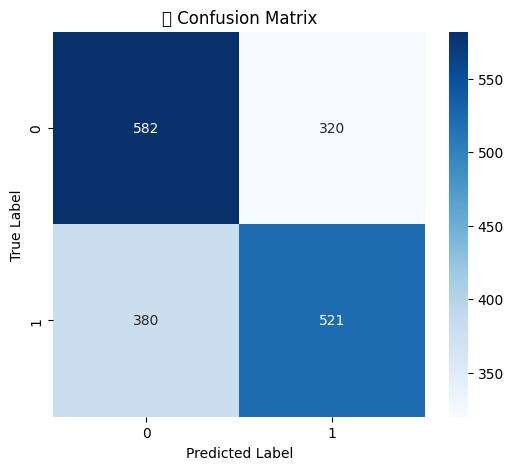

In [ ]:
#confusion matrix pre model BiLSTM
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#výpočet matice chýb
cm = confusion_matrix(test_labels, predictions_binary)

#vykreslenie matice
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
